In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as img
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2 as cv
import torch.nn as nn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
data_loc = "data/"
train_labels = pd.read_csv(data_loc+'train.csv')
test_labels = pd.read_csv(data_loc+'test.csv')

In [3]:
test_labels

,img_path,printer_id,print_id
0,101/1678578332/1678578538.704966.jpg,101,1678578332
1,101/1678578332/1678578539.108019.jpg,101,1678578332
2,101/1678578332/1678578539.512872.jpg,101,1678578332
3,101/1678578332/1678578539.916711.jpg,101,1678578332
4,101/1678578332/1678578540.329089.jpg,101,1678578332
...,...,...,...
25274,022/1672795514/1672796229.177132.jpg,22,1672795514
25275,022/1672795514/1672796230.177629.jpg,22,1672795514
25276,022/1672795514/1672796231.187994.jpg,22,1672795514
25277,022/1672795514/1672796232.19111.jpg,22,1672795514


In [4]:
train_labels

,img_path,printer_id,print_id,has_under_extrusion
0,101/1678589738/1678589914.060332.jpg,101,1678589738,1
1,101/1678589738/1678589914.462857.jpg,101,1678589738,1
2,101/1678589738/1678589914.875075.jpg,101,1678589738,1
3,101/1678589738/1678589915.284495.jpg,101,1678589738,1
4,101/1678589738/1678589915.700486.jpg,101,1678589738,1
...,...,...,...,...
81055,022/1672857603/1672858113.083624.jpg,22,1672857603,1
81056,022/1672857603/1672858114.101455.jpg,22,1672857603,1
81057,022/1672857603/1672858115.107314.jpg,22,1672857603,1
81058,022/1672857603/1672858116.11023.jpg,22,1672857603,1


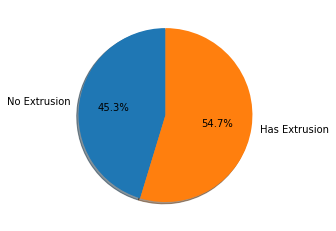

1    44342
0    36718
Name: has_under_extrusion, dtype: int64


In [12]:
label = 'No Extrusion', 'Has Extrusion'
plt.figure(figsize = (4,4))
plt.pie(train_labels.groupby('has_under_extrusion').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()
print(train_labels['has_under_extrusion'].value_counts())

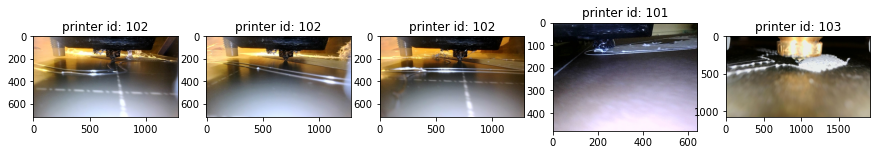

In [13]:
image_loc = data_loc+"images/"

# Images under extrusion
fig,ax = plt.subplots(1,5,figsize=(15,3))
for i,(img_path) in enumerate(np.random.choice(train_labels[train_labels['has_under_extrusion']==1]['img_path'].values,5)):
    ax[i].imshow(img.imread(image_loc+img_path))
    ax[i].set_title("printer id: {}".format(img_path.split('/')[0]))

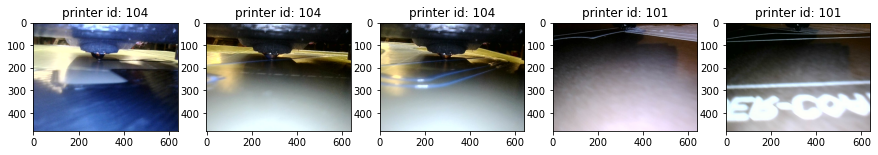

In [14]:
# Images not under extrusion
fig,ax = plt.subplots(1,5,figsize=(15,3))

for i,(img_path) in enumerate(np.random.choice(train_labels[train_labels['has_under_extrusion']==0]['img_path'].values,5)):
    ax[i].imshow(img.imread(image_loc+img_path))
    ax[i].set_title("printer id: {}".format(img_path.split('/')[0]))

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [17]:
class PrinterDataset(torch.utils.data.Dataset):
    def __init__(self, data, path , image_loc, transform = None):
        super().__init__()
        self.data = data
        self.img_path = path
        self.transform = transform
        self.image_loc = image_loc
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        label = torch.tensor(self.data.values[index]).long().to(device)
        img_path = self.img_path.values[index]
        image = img.imread(self.image_loc+img_path)
        if self.transform is not None:
            # image = cv.normalize(image, None, 255, 0, cv.NORM_MINMAX, cv.CV_8U)
            # lap = cv.Laplacian(image, cv.CV_64F)
            # edges = cv.Canny(image, 150, 150)
            image = self.transform(image)
        image = image.float().to(device)
        return image, label, img_path

In [18]:
for i in train_labels['printer_id'].unique():
#     print(train_labels['printer_id']==i)
    path = train_labels[train_labels['printer_id']==i]['img_path'].values[0]
#     print(path)
    print(img.imread(image_loc + path).shape)

(480, 640, 3)
(720, 1280, 3)
(1080, 1920, 3)
(480, 640, 3)
(720, 1280, 3)


In [19]:
# Hyper parameters

num_epochs = 5
num_classes = 2
batch_size = 50
learning_rate = 0.001
image_resize = (224, 224)
# train_mean = [0.4548, 0.4494, 0.4273]
# train_std = [0.3017, 0.3058, 0.3260]

In [20]:
image_transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize(image_resize), transforms.ToTensor(), 
                                    transforms.RandomHorizontalFlip(p=0.5)])
# train, dev = train_test_split(train_labels, stratify=train_labels['has_under_extrusion'], test_size=0)

train_data = PrinterDataset(train_labels['has_under_extrusion'], train_labels['img_path'], image_loc, image_transform)
# dev_data = PrinterDataset(dev['has_under_extrusion'], dev['img_path'], image_loc, image_transform)
test_data = PrinterDataset(pd.DataFrame(np.ones(len(test_labels))), test_labels['img_path'], image_loc, image_transform)

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
# dev_loader = torch.utils.data.DataLoader(dataset = dev_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [21]:
# def batch_mean_and_sd(loader):
    
#     cnt = 0
#     fst_moment = torch.empty(3)
#     snd_moment = torch.empty(3)

#     for images, _, _ in tqdm(loader):
#         b, c, h, w = images.shape
#         nb_pixels = b * h * w
#         sum_ = torch.sum(images, dim=[0, 2, 3])
#         sum_of_square = torch.sum(images ** 2,
#                                   dim=[0, 2, 3])
#         fst_moment = (cnt * fst_moment + sum_) / (
#                       cnt + nb_pixels)
#         snd_moment = (cnt * snd_moment + sum_of_square) / (
#                             cnt + nb_pixels)
#         cnt += nb_pixels

#     mean, std = fst_moment, torch.sqrt(
#       snd_moment - fst_moment ** 2)        
#     return mean,std
  
# mean, std = batch_mean_and_sd(train_loader)
# print("mean and std: \n", mean, std)

In [22]:
trainimages, trainlabels, _ = next(iter(train_loader))

training images
(224, 224)
(224, 224)
(224, 224)
(224, 224)
(224, 224)
torch.Size([3, 224, 224])


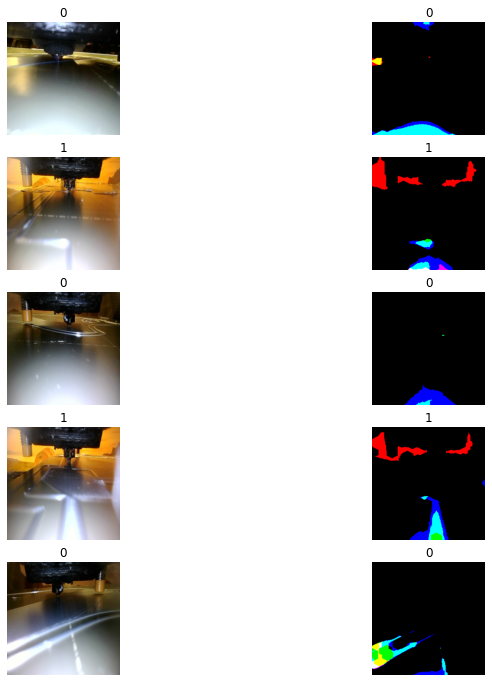

In [47]:
def imshow(image, axes=None, title=None):
    if axes is None:
        fig, ax = plt.subplots()
#     print(image.shape)
    image = torch.permute(image, (1, 2, 0)).to('cpu').numpy()
    
    ax = axes[0]
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)
    
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
#     print(hsv)
    lower_white = np.array([20,0,0])
    upper_white = np.array([255,200,255])
    
    mask = cv.inRange(hsv, lower_white, upper_white)
    res = cv.bitwise_and(image, image, mask = mask)
    image = np.array(image, np.uint8)

    image = cv.normalize(image, None, 255, 0, cv.NORM_MINMAX, cv.CV_8U)
    lap = cv.Laplacian(image, cv.CV_64F)
    edges = cv.Canny(image, 300, 300)

    print(edges.shape)
    kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(5,5))
    image = cv.dilate(image, kernel, iterations=5)
    image = cv.erode(image, kernel, iterations=5)
    
    cv.erode(image,kernel,iterations = 1)
    
    ax = axes[1]
    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    ax.set_title(title)

    return ax

fig, axes = plt.subplots(figsize=(12, 12), ncols=2, nrows=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], axes=axe1, title=trainlabels[i].item())

print(trainimages[0].size())

In [24]:
def train_model(model, train_loader, num_epochs):
    # keeping-track-of-losses 
    train_losses = []
#     valid_losses = []
    min_loss = float('inf')
    
    for epoch in range(1, num_epochs + 1):
        # keep-track-of-training-and-validation-loss
        train_loss = 0.0
#         valid_loss = 0.0

        # training-the-model
        model.train()
        for data, target, _ in tqdm(train_loader):
            # clear-the-gradients-of-all-optimized-variables
            optimizer.zero_grad()
            # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
            output = model(data)
            # calculate-the-batch-loss
            loss = criterion(output, target)
            # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
            loss.backward()
            # perform-a-ingle-optimization-step (parameter-update)
            optimizer.step()
            # update-training-loss
            train_loss += loss.item() * data.size(0)
    
        if(train_loss<min_loss):
            min_loss = train_loss
            torch.save(model.state_dict(), 'model.ckpt')

#         # validate-the-model
#         model.eval()
#         for data, target, _ in valid_loader:
            
#             output = model(data)

#             loss = criterion(output, target)
        
#             # update-average-validation-loss 
#             valid_loss += loss.item() * data.size(0)
    
        # calculate-average-losses
        train_loss = train_loss/len(train_loader.sampler)
#         valid_loss = valid_loss/len(valid_loader.sampler)
        train_losses.append(train_loss)
#         valid_losses.append(valid_loss)
        
        # print-training/validation-statistics 
        print('Epoch: {} \tTraining Loss: {:.6f}'.format(
            epoch, train_loss))
    
    return train_losses

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=3)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(720, 1024)
        self.fc2 = nn.Linear(1024, 2)

    def forward(self, x):
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        print(x.shape)
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        print(x.shape)
        x = x.view(x.shape[0],-1)
        print(x.shape)
        x = F.relu(self.fc1(x))
        print(x.shape)
        x = F.dropout(x, training=self.training)
        print(x.shape)
        x = self.fc2(x)
        return x

In [40]:
from residual_attention_network import ResidualAttentionModel_56

epochs = 5
batch_size = 32
learning_rate = 0.001

model = ResidualAttentionModel_56()
print(model)

ResidualAttentionModel_56(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (mpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_block1): ResidualBlock(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv4): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False

In [42]:
%%time
model = ResidualAttentionModel_56().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
train_losses = train_model(model, train_loader, epochs)

  0%|          | 2/1622 [00:45<10:11:55, 22.66s/it]


KeyboardInterrupt: 

In [43]:
# %%time
# model = CNN().to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)
# train_losses, valid_losses = train_model(model, train_loader, None)

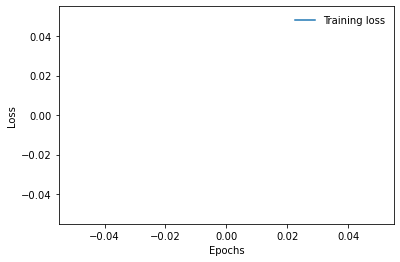

In [44]:

plt.plot(train_losses, label='Training loss')
# plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [46]:
# Test
model.eval()  # it-disables-dropout
torch.save(model.state_dict(), 'model.ckpt')
res = pd.DataFrame()
        
with torch.no_grad():
    correct = 0
    total = 0
    for images, _, path in tqdm(test_loader):
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        res = pd.concat((res,pd.DataFrame([[p,int(l.item())] for p,l in zip(path,predicted)], columns=['img_path','has_under_extrusion'])))
        
res.to_csv('submission.csv', index=False)

  1%|          | 4/506 [00:15<32:52,  3.93s/it]


KeyboardInterrupt: 